In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score 



def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)


In [187]:
train = pd.read_csv('../raw_data/train.csv', index_col = 0)
test = pd.read_csv('../raw_data/test.csv', index_col = 0)


train['instrumentalness'] = np.log(train['instrumentalness'] + 1) 
useful_cols = [col for col in train.columns if col not in ['id', 'song_popularity']]
missing_cols = [col for col in train.columns if train[col].isna().sum() > 0]
cols_dist_missing = [col for col in missing_cols if col not in ['key', 'audio_mode', 'time_signature']]
cols_mode_missing = [col for col in missing_cols if col in ['key', 'audio_mode', 'time_signature']]

# print(missing_cols)
for col in cols_dist_missing:
    # print(col)
    train[col].fillna(train[col].median(), inplace = True)

for col in cols_mode_missing:
    # print(col)
    train[col].fillna(train[col].mode()[0], inplace = True)



X_train, X_valid, y_train, y_valid = train_test_split(train[useful_cols], train['song_popularity'], test_size=0.2, random_state=42)


['song_duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness']
song_duration_ms
acousticness
danceability
energy
instrumentalness
liveness
loudness
key


In [188]:
missing_cols2 = [col for col in train.columns if train[col].isna().sum() > 0]
print(missing_cols2)

[]


In [189]:
clf = RandomForestClassifier(n_estimators=100, min_samples_leaf=15, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=15, random_state=42)

In [190]:
clf.score(X_train, y_train)


0.716625

In [191]:
clf.score(X_valid, y_valid)

0.636625

In [192]:
LR_AUC = roc_auc_score(y_valid, clf.predict(X_valid))
print("AUC: " + str(LR_AUC))

AUC: 0.5057593185509541


/home/kevin/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

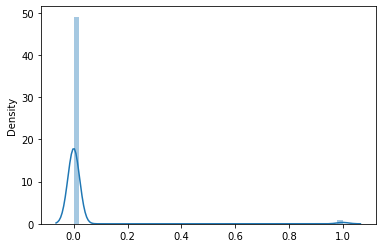

In [193]:
# np.mean(clf.predict(X_valid))
sns.distplot(clf.predict(X_valid))

The imbalance in song popularity is an issue as it seems that the model is mostly predicting not popular. It is thus necessary to find a way to manage it.

In [113]:
fi = rf_feat_importance(clf, X_train)
fi[:5]

,cols,imp
12,audio_valence,0.098609
3,energy,0.097154
4,instrumentalness,0.096626
6,liveness,0.095656
10,tempo,0.095593


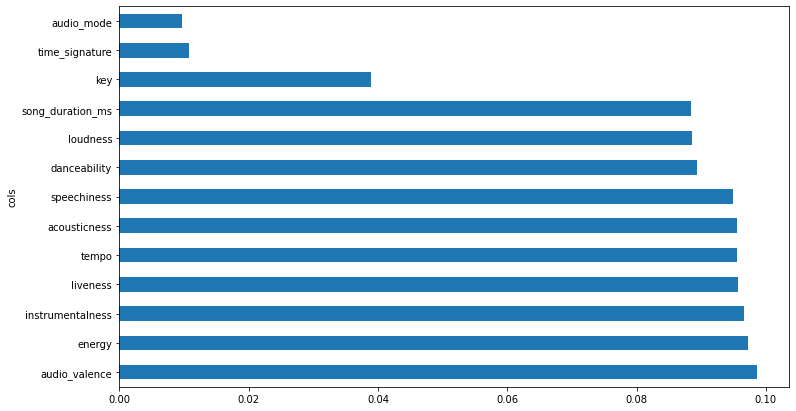

In [114]:
def plot_fi(fi): 
  return fi.plot('cols','imp','barh', figsize=(12,7), legend=False)

plot_fi(fi);

Let's try to remove one or two useless features

In [115]:
to_keep = fi[fi.imp>0.01].cols
len(to_keep)


12

In [116]:
useful_cols = [col for col in train.columns if col not in ['id', 'song_popularity']]

df_keep = train[to_keep].copy()

X_train, X_valid, y_train, y_valid = train_test_split(df_keep, train['song_popularity'], test_size=0.2, random_state=42)

In [117]:
m = RandomForestClassifier(n_estimators=100, min_samples_leaf=10, n_jobs=-1, max_features="sqrt")
m.fit(X_train, y_train)

m.score(X_train, y_train)


0.7968125

In [118]:
m.score(X_valid, y_valid)

0.635875

In [119]:
LR_AUC = roc_auc_score(y_valid, m.predict(X_valid))
print("AUC: " + str(LR_AUC))

AUC: 0.508036746665115


## Partial dependence

<AxesSubplot:xlabel='audio_valence', ylabel='energy'>

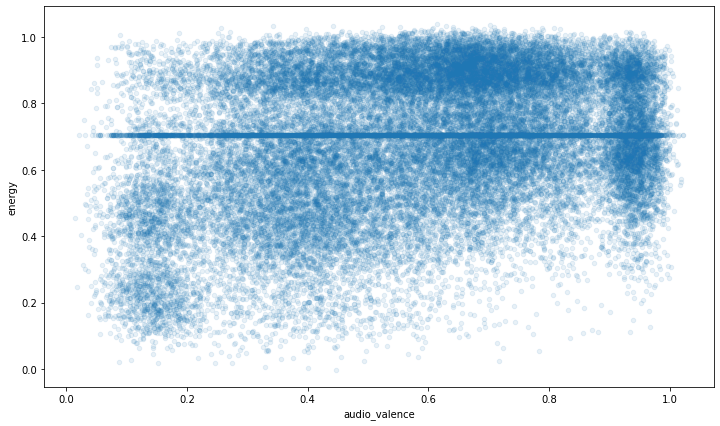

In [120]:
train.plot('audio_valence','energy','scatter', figsize=(12,7), alpha = 0.1)

In [123]:
import pdpbox as pdp
def plot_pdp(feat,m,x, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, 
                        n_cluster_centers=clusters)

ModuleNotFoundError: No module named 'pdpbox'

In [122]:
plot_pdp('audio_valence', m, X_train, clusters=None, feat_name='audio_valence')

AttributeError: module 'pdp' has no attribute 'pdp_isolate'

## Imbalanced Study


In [213]:
train = pd.read_csv('../raw_data/train.csv', index_col = 0)
test = pd.read_csv('../raw_data/test.csv', index_col = 0)

train['instrumentalness'] = np.log(train['instrumentalness'] + 1) 
useful_cols = [col for col in train.columns if col not in ['id', 'song_popularity']]
missing_cols = [col for col in train.columns if train[col].isna().sum() > 0]
cols_dist_missing = [col for col in missing_cols if col not in ['key', 'audio_mode', 'time_signature']]
cols_mode_missing = [col for col in missing_cols if col in ['key', 'audio_mode', 'time_signature']]

# print(missing_cols)
for col in cols_dist_missing:
    # print(col)
    train[col].fillna(train[col].median(), inplace = True)

for col in cols_mode_missing:
    # print(col)
    train[col].fillna(train[col].mode()[0], inplace = True)

X_train, X_valid, y_train, y_valid = train_test_split(train[useful_cols], train['song_popularity'], test_size=0.2, random_state=42)


In [195]:
clf = RandomForestClassifier(n_estimators=100, min_samples_leaf=15, random_state=42, class_weight='balanced')    
# it rebalances the class weights by the inverse of the class frequency
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=15,
                       random_state=42)

In [196]:
print(clf.score(X_train, y_train))
print(clf.score(X_valid, y_valid))
LR_AUC = roc_auc_score(y_valid, clf.predict_proba(X_valid)[:,1])
print("AUC: " + str(LR_AUC))

0.8915625
0.588125
AUC: 0.5612101164034565


**Bootstramp class weighting**

In [214]:
clf_bcw = RandomForestClassifier(n_estimators=100, min_samples_leaf=15, random_state=42, class_weight='balanced_subsample')
clf_bcw.fit(X_train, y_train)
print(clf_bcw.score(X_train, y_train))
print(clf_bcw.score(X_valid, y_valid))
LR_AUC = roc_auc_score(y_valid, clf_bcw.predict_proba(X_valid)[:,1])
print("AUC: " + str(LR_AUC))

0.89115625
0.58875
AUC: 0.563753305217287


In [198]:
from imblearn.ensemble import BalancedRandomForestClassifier

clf_bal = BalancedRandomForestClassifier(n_estimators=100, min_samples_leaf=10, random_state=42)
clf_bal.fit(X_train, y_train)
print(clf_bal.score(X_train, y_train))
print(clf_bal.score(X_valid, y_valid))
LR_AUC = roc_auc_score(y_valid, clf_bal.predict_proba(X_valid)[:,1])
print("AUC: " + str(LR_AUC))

0.85609375
0.53525
AUC: 0.5607915281132225


array([0.53662693, 0.50127402, 0.51081069, ..., 0.48934708, 0.68486518,
       0.41276349])

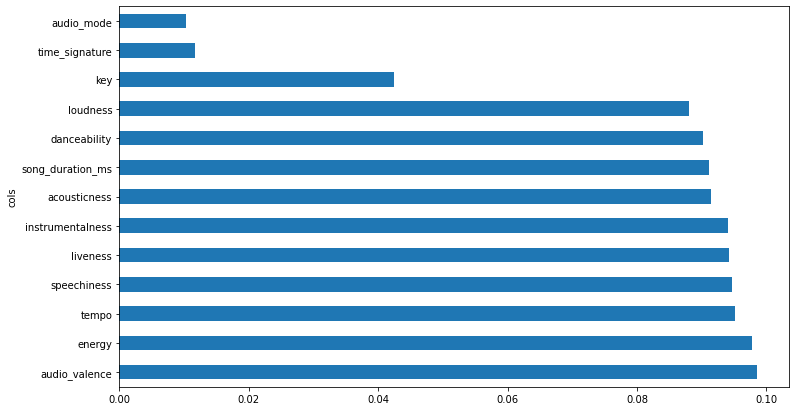

In [199]:
fi_bal = rf_feat_importance(clf_bal, X_train)
plot_fi(fi_bal);

Random Forest are more or less robust to outliers as they are binning them together (to be detailed). However they are unable to capture any nonlinear features.

What is the effect of adding the PCA components into a RF algorithm?

In [200]:
from sklearn import decomposition


pca = decomposition.PCA(n_components=3)
pca.fit(train[useful_cols])
pca_train = pca.transform(train[useful_cols])

columns = ['pca_%i' % i for i in range(3)]
train[columns] = pca_train
useful_cols = [col for col in train.columns if col not in ['id', 'song_popularity']]

X_train, X_valid, y_train, y_valid = train_test_split(train[useful_cols], train['song_popularity'], test_size=0.2, random_state=42)


In [201]:
clf_bcw = RandomForestClassifier(n_estimators=100, min_samples_leaf=15, random_state=42, class_weight='balanced_subsample')
clf_bcw.fit(X_train, y_train)
print(clf_bcw.score(X_train, y_train))
print(clf_bcw.score(X_valid, y_valid))
LR_AUC = roc_auc_score(y_valid, clf_bcw.predict_proba(X_valid)[:,1])
print("AUC: " + str(LR_AUC))

0.9075
0.590125
AUC: 0.5629336120051742


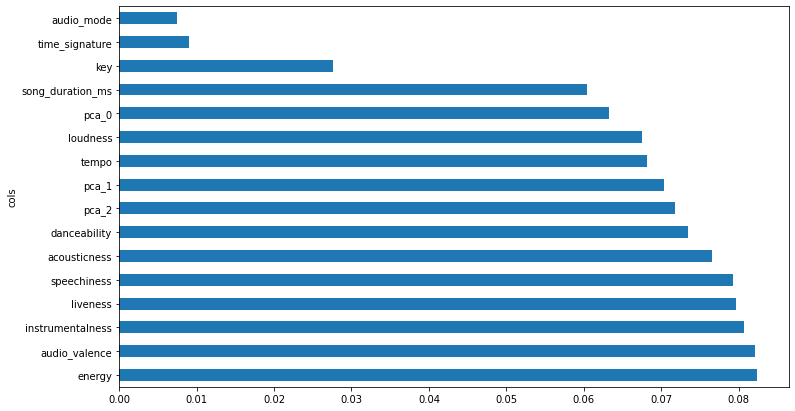

In [202]:
fi_bcw = rf_feat_importance(clf_bcw, X_train)
plot_fi(fi_bcw);

## Submitting an Imbalanced RFC

In [215]:
test = pd.read_csv('../raw_data/test.csv', index_col = 0)
test['instrumentalness'] = np.log(test['instrumentalness'] + 1)

useful_cols = [col for col in test.columns if col not in ['id', 'song_popularity']]
missing_cols = [col for col in test.columns if test[col].isna().sum() > 0]
cols_dist_missing = [col for col in missing_cols if col not in ['key', 'audio_mode', 'time_signature']]
cols_mode_missing = [col for col in missing_cols if col in ['key', 'audio_mode', 'time_signature']]

# print(missing_cols)
for col in cols_dist_missing:
    # print(col)
    test[col].fillna(test[col].median(), inplace = True)

for col in cols_mode_missing:
    # print(col)
    test[col].fillna(test[col].mode()[0], inplace = True)

In [216]:
submission = pd.read_csv('../raw_data/sample_submission.csv', index_col = 0)

In [217]:
submission['song_popularity'] = clf_bcw.predict_proba(test[useful_cols])[:,1]

In [218]:
submission.head()

,song_popularity
id,
0,0.554487
1,0.564694
2,0.349793
3,0.425353
4,0.481376


In [220]:
submission.to_csv('../submissions/submission_rf_balanced_subsample.csv')